In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200
import plot_utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

In [4]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

# Load labeled dataset

In [5]:
transform = torchvision.transforms.ToTensor()

# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [6]:
sample, target, road_image, extra = labeled_trainset[5]
sample.shape

torch.Size([6, 3, 256, 306])

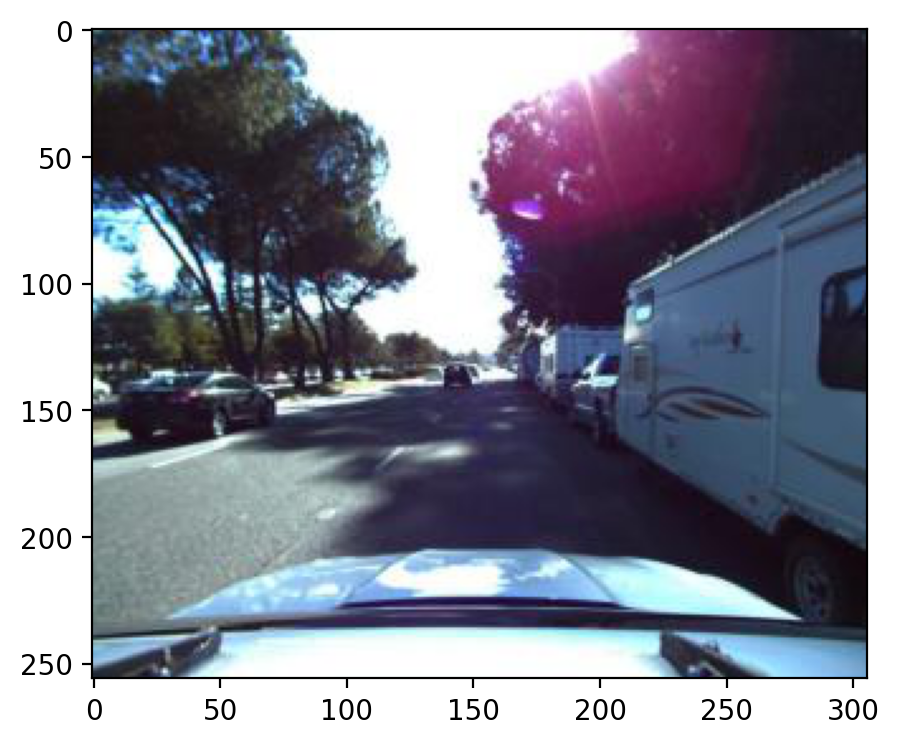

In [7]:
plot_utils.plot_photos(sample[1])

In [8]:
car_idces = np.arange(25) # [7]#,9, 16,17,18]

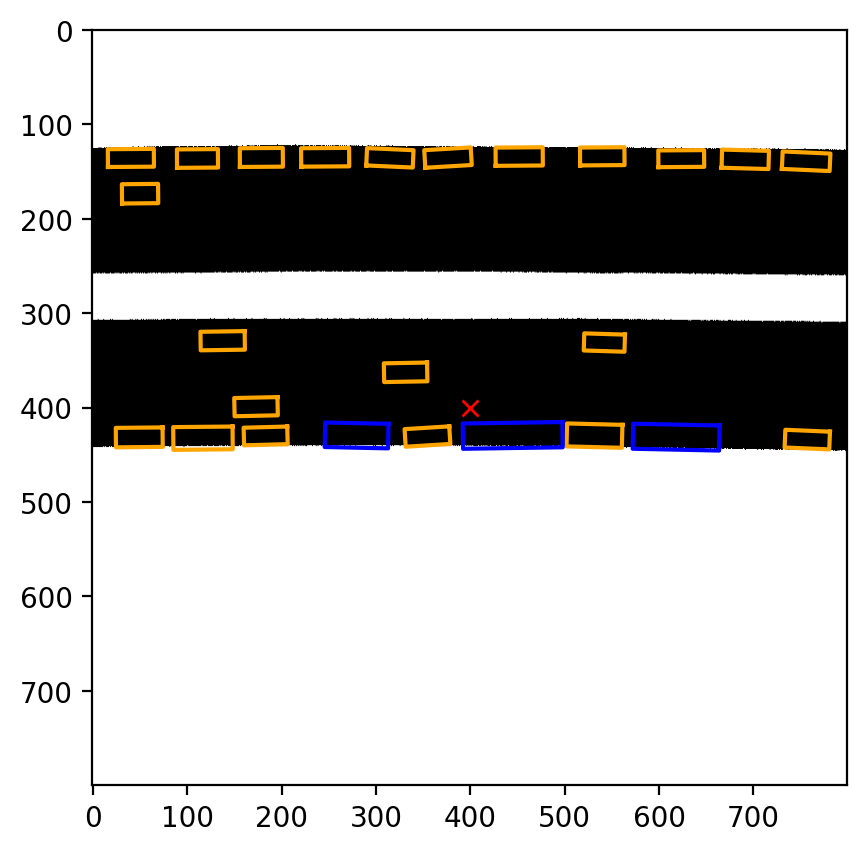

In [9]:
plot_utils.plot_bb(
    road_image, target, 
    b_slc=car_idces
)

# Projections

In [10]:
from importlib import reload

In [11]:
import projections
reload(projections)

<module 'projections' from '/home/marina/Documents/DL/project/ssl_project/projections.py'>

In [13]:
from utils import to_np

In [15]:


# fig, axis = plt.subplots(1, 1)
# plot_utils.plot_bb(
#     road_image, target, 
#     b_slc=car_idces[proj_plane.is_valid(cars_n)],
#     axis=axis
# )

# x = np.linspace(0, 800,100)
# for k in [
# #     np.sqrt(3),   -np.sqrt(3),
#           np.sqrt(1/3), -np.sqrt(1/3), ]:
#     axis.plot(x, 400 + k * (x - 400))
    
# axis.axvline(400)


In [16]:
sample, target, road_image, extra = labeled_trainset[2500]
sample.shape

# boounding box
# (7,8)----------(3,4)
#   |              |
# (5,6)----------(1,2)

cars_n = np.array([
    to_np(target["bounding_box"][car_idx].T)
    for car_idx in range(len(target["bounding_box"]))
])

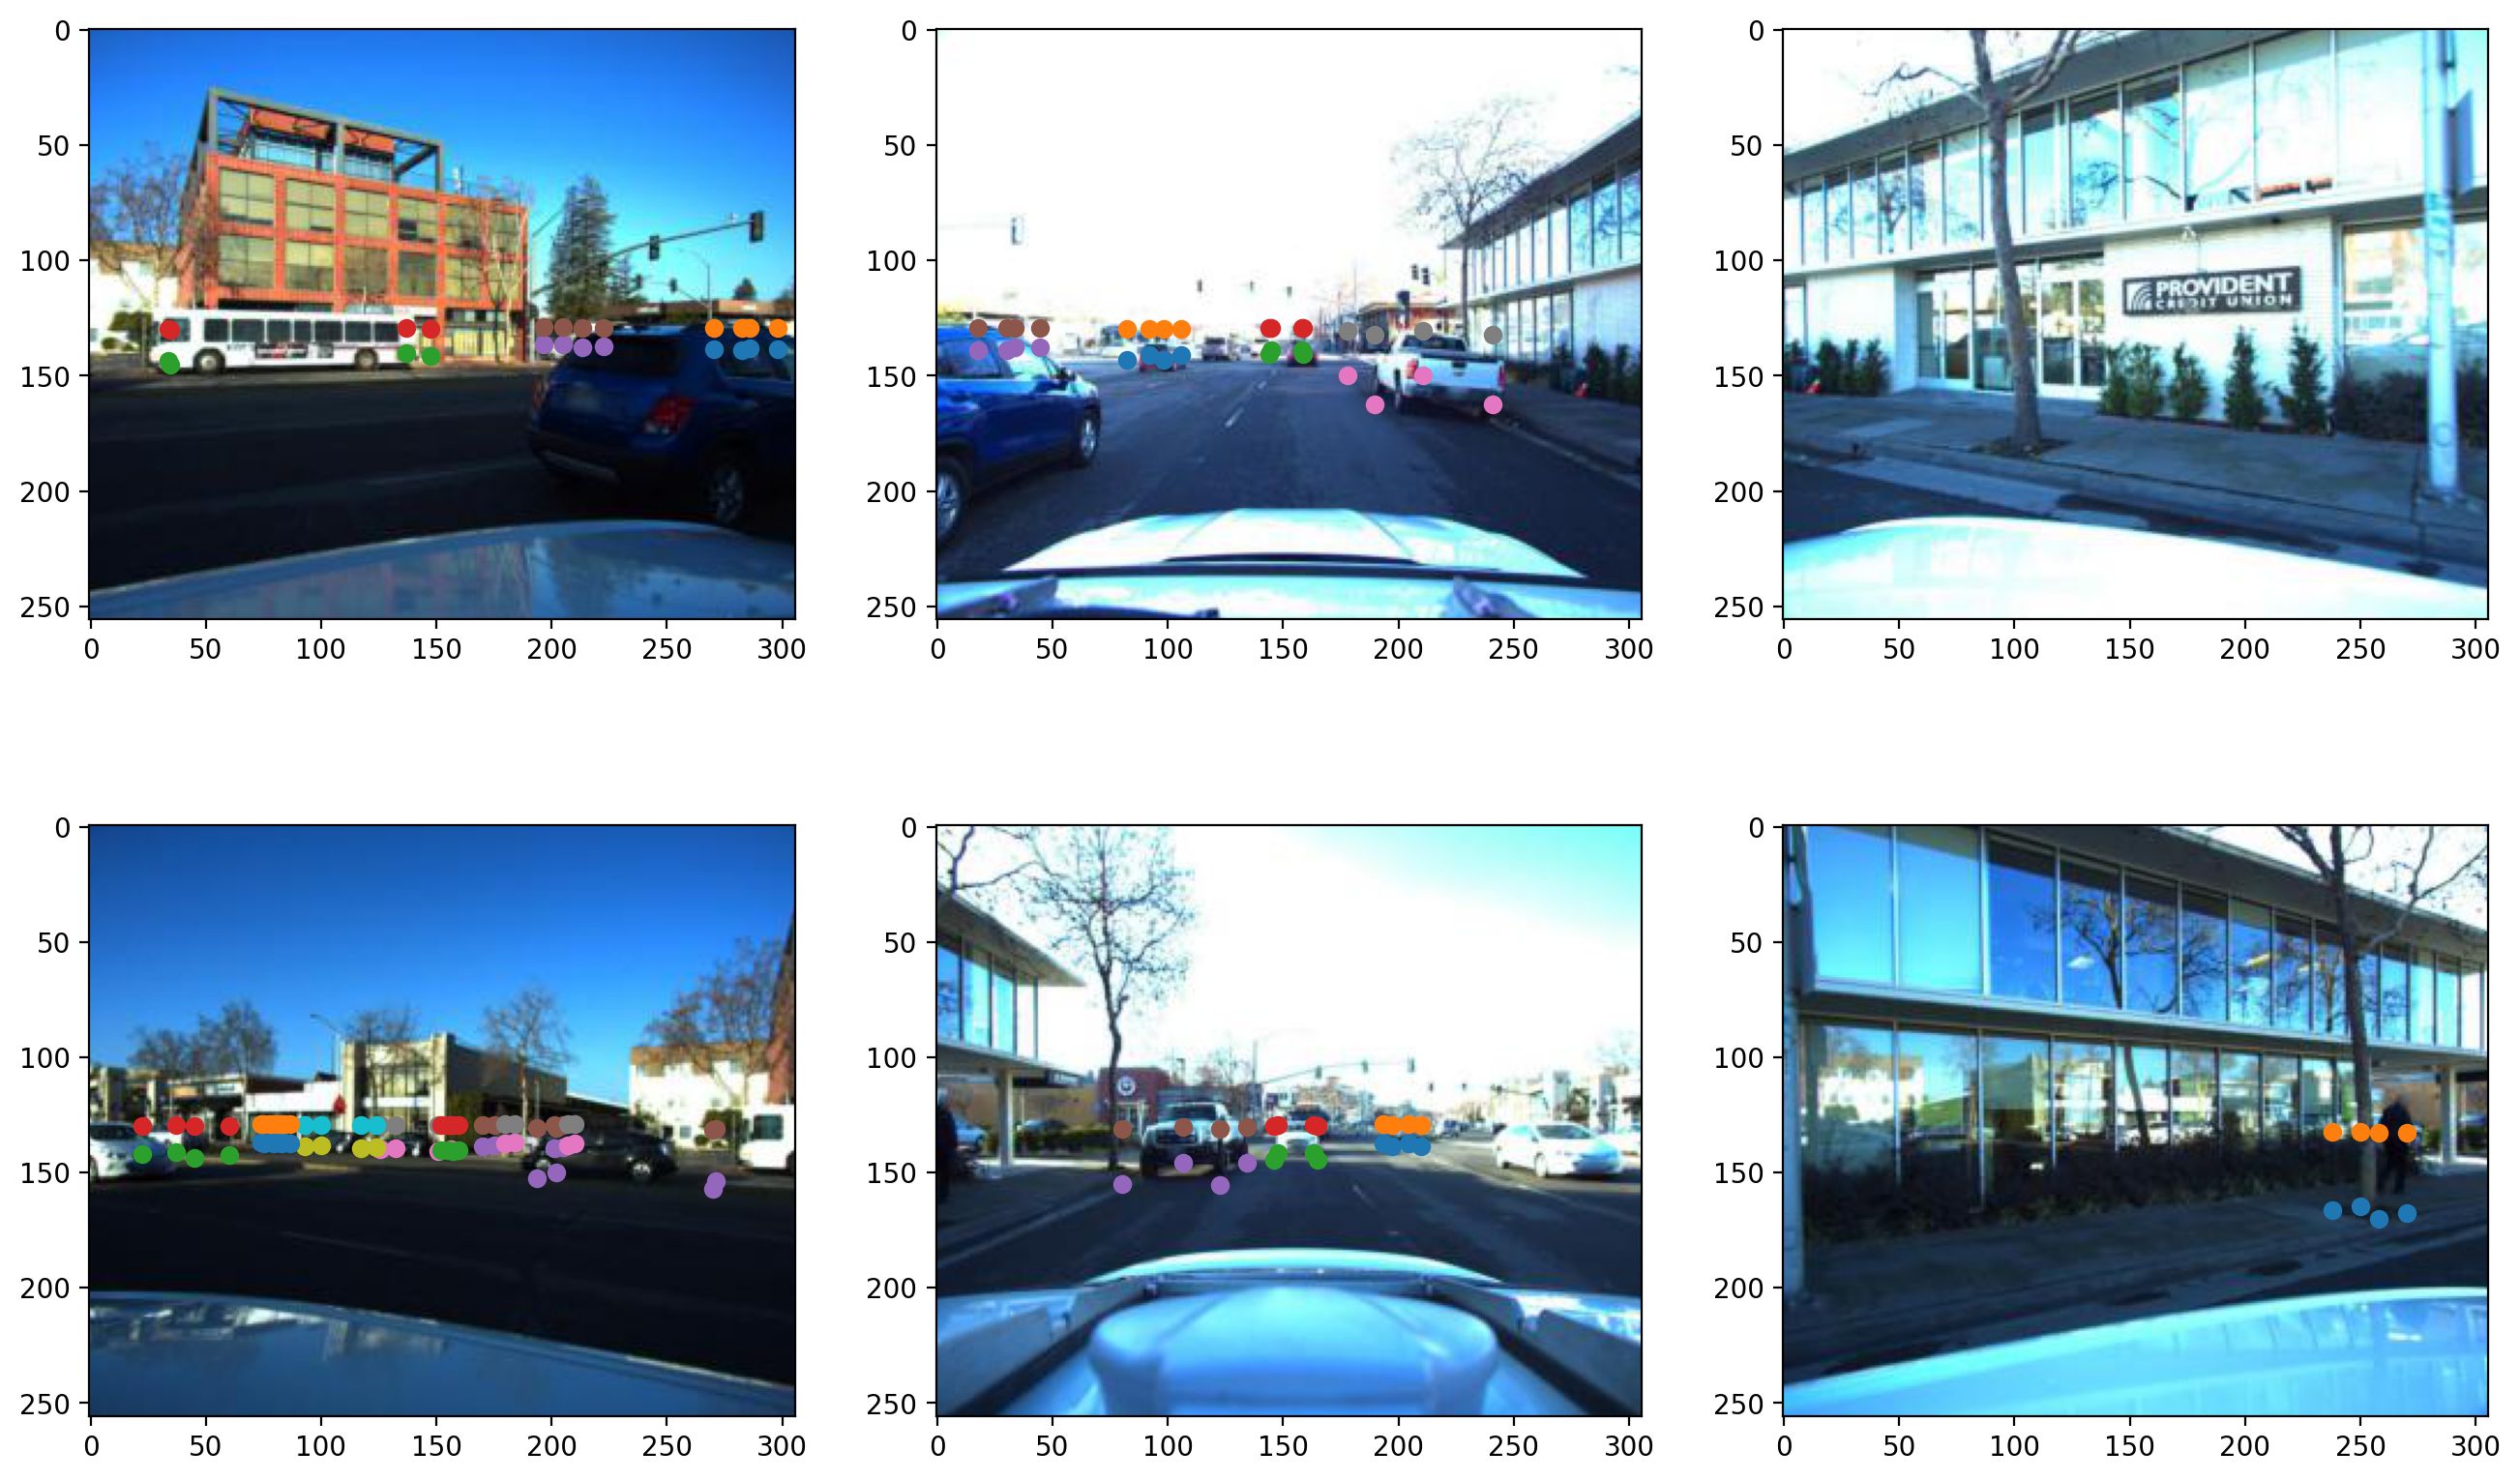

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

cam_names = ["CAM_FRONT_LEFT", "CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_LEFT", "CAM_BACK", "CAM_BACK_RIGHT"]
cam_angle = [60,                    0,             -60,           120,            180,          -120]
idx_to_angle = dict(enumerate(cam_angle))

for photo_idx in range(6):
    proj_plane = projections.ProjectionPlane(1.7, 70, idx_to_angle[photo_idx])
    
    axis=axes[photo_idx]

    plot_utils.plot_photos(sample[photo_idx], axis=axis)
    for idx, (valid, yz_42, yz_42_top) in enumerate(zip(proj_plane.is_valid(cars_n),
                                             proj_plane(cars_n), proj_plane(cars_n, 1.5))): # [[0,1,2,4]])):
        if valid:
            axis.scatter(yz_42[:, 0],     yz_42[:, 1], label=idx)
            axis.scatter(yz_42_top[:, 0], yz_42_top[:, 1], label=idx)
